This Notebook/demo uses spike interface, [here is how to install Spike Interface](https://spikeinterface.readthedocs.io/en/stable/get_started/installation.html)

In the SI environment:

`pip install UnitMatchPy`

In [1]:
import sys
from pathlib import Path

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import UnitMatchPy.extract_raw_data as erd
import numpy as np 

c:\Users\EnnyB\anaconda3\envs\DUM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data & get good units

Spike Interface can load in many different types of Ephys data look [here](https://spikeinterface.readthedocs.io/en/latest/modules/extractors.html) for documentation on function to read in different data formats. [Example data can be found here.](https://figshare.com/articles/dataset/UnitMatch_Demo_-_data/24305758/1)

In [ ]:
#Make list of recordings/sortings to iterate over
recordings = [se.read_spikeglx(r'path/to/SpikeGLX/data', stream_name="imec0.ap")] # Note, only applicable when you don't have the raw waveforms yet. SKIP when using our demo data.

# Note, read_kilosort will only read good units by default. To read all units, use the argument 'load_good_only=False'
KS_dirs = [r'\Path\to\1',r'\Path\to\2']
sortings = [se.read_kilosort(r'\Path\to\1',r'\Path\to\2')] 


## Process average waveforms / templates

Beaware the spike interface method is different to the native unitmatch method in ExtractRawDemo.ipynb or in the MatLab version

In [ ]:
# Pre-process the raw data
# Note, only applicable when you don't have the raw waveforms yet. SKIP when using our demo data. 
for recording in recordings:
    recording = spre.phase_shift(recording) #correct for time delay between recording channels
    recording = spre.highpass_filter(recording) #highpass

    # for motion correction, this can be very slow
    #Uncommented code below to do in session motion correction
    #recording = spre.correct_motion(recording, preset="nonrigid_fast_and_accurate")

NameError: name 'recordings' is not defined

In [ ]:
#Split each recording/sorting into 2 halves               
# # Note, only applicable when you don't have the raw waveforms yet. SKIP when using our demo data.     
for i, sorting in enumerate(sortings):
    split_idx = recordings[i].get_num_samples() // 2

    split_sorting = []
    split_sorting.append(sorting.frame_slice(start_frame=0, end_frame=split_idx))
    split_sorting.append(sorting.frame_slice(start_frame=split_idx, end_frame=recordings[i].get_num_samples()))

    sortings[i] = split_sorting 

for i, recording in enumerate(recordings):
    split_idx = recording.get_num_samples() // 2

    split_recording = []
    split_recording.append(recording.frame_slice(start_frame=0, end_frame=split_idx))
    split_recording.append(recording.frame_slice(start_frame=split_idx, end_frame=recording.get_num_samples()))

    recordings[i] = split_recording
 

NameError: name 'recordings' is not defined

In [ ]:
# create sorting analyzer for each pair
# Note, only applicable when you don't have the raw waveforms yet. SKIP when using our demo data. 

analysers = []
for i in range(len(recordings)):
    split_analysers = []

    split_analysers.append(si.create_sorting_analyzer(sortings[i][0], recordings[i][0], sparse=False))
    split_analysers.append(si.create_sorting_analyzer(sortings[i][1], recordings[i][1], sparse=False))
    analysers.append(split_analysers)

In [ ]:
#create the fast template extension for each sorting analyser
# Note, only applicable when you don't have the raw waveforms yet. SKIP when using our demo data. 
all_waveforms = []
for i in range(len(analysers)):
    for half in range(2):
        analysers[i][half].compute(
            "random_spikes",
            method="uniform",
            max_spikes_per_unit=500)
        
        #Analysers[i][half].compute('fast_templates', n_jobs = 0.8,  return_scaled=True)
        analysers[i][half].compute('fast_templates', n_jobs = 0.8)
    
    templates_first = analysers[i][0].get_extension('fast_templates')
    templates_second = analysers[i][1].get_extension('fast_templates')
    t1 = templates_first.get_data()
    t2 = templates_second.get_data()
    all_waveforms.append(np.stack((t1,t2), axis = -1))

#Make a channel_positions array
all_positions = []
for i in range(len(analysers)):
    #positions for first half and second half are the same
    all_positions.append(analysers[i][0].get_channel_locations())

## Save extracted data in a unit match friendly folder

In [ ]:
# Note, only applicable when you don't have the raw waveforms yet. SKIP when using our demo data. 

import os
UM_input_dir = os.path.join(os.getcwd(), 'UMInputData')

os.mkdir(UM_input_dir)

all_session_paths = []
for i in range(len(recordings)):
    session_x_path = os.path.join(UM_input_dir, f'Session{i+1}') #lets start at 1
    os.mkdir(session_x_path)

    #save the GoodUnits as a .rsv first column is unit ID,second is 'good' or 'mua'
    good_units_path = os.path.join(session_x_path, 'cluster_group.tsv')
    channel_positions_path = os.path.join(session_x_path, 'channel_positions.npy')
    save_good_units = np.vstack((np.array(('cluster_id', 'group')), good_units[i])) #Title of colum one is '0000' Not 'cluster_id')
    save_good_units[0,0] = 0 # need to be int to use np.savetxt 
    np.savetxt(good_units_path, save_good_units, fmt =['%d','%s'], delimiter='\t')
    if extract_good_units_only:
        Units = np.argwhere(good_units[0][:,1] == 'good')
        erd.save_avg_waveforms(all_waveforms[i], session_x_path, Units, extract_good_units_only=extract_good_units_only)
    else:
        erd.save_avg_waveforms(all_waveforms[i], session_x_path, good_units[i], extract_good_units_only=extract_good_units_only)
    np.save(channel_positions_path, all_positions[i])

    all_session_paths.append(session_x_path)

## Run UnitMatch

In [16]:
%load_ext autoreload
%autoreload 

import UnitMatchPy.bayes_functions as bf
import UnitMatchPy.utils as util
import UnitMatchPy.overlord as ov
import numpy as np
import matplotlib.pyplot as plt
import UnitMatchPy.save_utils as su
import UnitMatchPy.GUI as gui
import UnitMatchPy.assign_unique_id as aid
import UnitMatchPy.default_params as default_params

In [26]:
#get default parameters, can add your own before or after!

# default of Spikeinterface as by default spike interface extracts waveforms in a different manner.
param = {'SpikeWidth': 90, 'waveidx': np.arange(20,50), 'PeakLoc': 35}
param = default_params.get_default_param()


param['KS_dirs'] = KS_dirs
wave_paths, unit_label_paths, channel_pos = util.paths_from_KS(KS_dirs)
param = util.get_probe_geometry(channel_pos[0], param)

Using cluster_group.tsv
Using cluster_group.tsv


In [27]:
def zero_center_waveform(waveform):
    """
    Centers waveform about zero, by subtracting the mean of the first 15 time points.
    This function is useful for Spike Interface where the waveforms are not centered about 0.

    Arguments:
        waveform - ndarray (nUnits, Time Points, Channels, CV)

    Returns:
        Zero centered waveform
    """
    waveform = waveform -  np.broadcast_to(waveform[:,:15,:,:].mean(axis=1)[:, np.newaxis,:,:], waveform.shape)
    return waveform

In [30]:
#read in data and select the good units and exact metadata
waveform, session_id, session_switch, within_session, good_units, param = util.load_good_waveforms(wave_paths, unit_label_paths, param, good_units_only = True) 

#param['peak_loc'] = #may need to set as a value if the peak location is NOT ~ half the spike width

# create clus_info, contains all unit id/session related info
clus_info = {'good_units' : good_units, 'session_switch' : session_switch, 'session_id' : session_id, 
            'original_ids' : np.concatenate(good_units) }

#Extract parameters from waveform
extracted_wave_properties = ov.extract_parameters(waveform, channel_pos, clus_info, param)

#Extract metric scores
total_score, candidate_pairs, scores_to_include, predictors  = ov.extract_metric_scores(extracted_wave_properties, session_switch, within_session, param, niter  = 2)

#Probability analysis
prior_match = 1 - (param['n_expected_matches'] / param['n_units']**2 ) # freedom of choose in prior prob
priors = np.array((prior_match, 1-prior_match))

labels = candidate_pairs.astype(int)
cond = np.unique(labels)
score_vector = param['score_vector']
parameter_kernels = np.full((len(score_vector), len(scores_to_include), len(cond)), np.nan)

parameter_kernels = bf.get_parameter_kernels(scores_to_include, labels, cond, param, add_one = 1)

probability = bf.apply_naive_bayes(parameter_kernels, priors, predictors, param, cond)

output_prob_matrix = probability[:,1].reshape(param['n_units'],param['n_units'])

The percentage of units matched to themselves is: 90.88%
The percentage of false -ve's then is: 9.12% 

The rate of miss-match(es) per expected match 0.14
The percentage of false +ve's is 0.05% for session 1
The percentage of false +ve's is 0.05% for session 2

This assumes that the spike sorter has made no mistakes


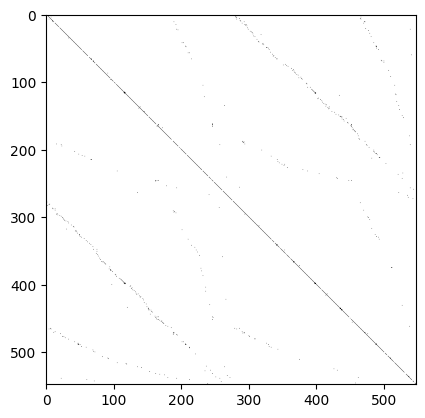

In [31]:
util.evaluate_output(output_prob_matrix, param, within_session, session_switch, match_threshold = 0.75)

match_threshold = param['match_threshold']
#match_threshold = try different values here!

output_threshold = np.zeros_like(output_prob_matrix)
output_threshold[output_prob_matrix > match_threshold] = 1

plt.imshow(output_threshold, cmap = 'Greys')


In [32]:
amplitude = extracted_wave_properties['amplitude']
spatial_decay = extracted_wave_properties['spatial_decay']
avg_centroid = extracted_wave_properties['avg_centroid']
avg_waveform = extracted_wave_properties['avg_waveform']
avg_waveform_per_tp = extracted_wave_properties['avg_waveform_per_tp']
wave_idx = extracted_wave_properties['good_wave_idxs']
max_site = extracted_wave_properties['max_site']
max_site_mean = extracted_wave_properties['max_site_mean']
gui.process_info_for_GUI(output_prob_matrix, match_threshold, scores_to_include, total_score, amplitude, spatial_decay,
                         avg_centroid, avg_waveform, avg_waveform_per_tp, wave_idx, max_site, max_site_mean, 
                         waveform, within_session, channel_pos, clus_info, param)

In [33]:
is_match, not_match, matches_GUI = gui.run_GUI()

Could not load ACG cache from acg_cache.pkl: [Errno 2] No such file or directory: 'acg_cache.pkl'
Icon path: c:\Users\EnnyB\anaconda3\envs\DUM\lib\site-packages\UnitMatchPy\GUI_icon.png
File exists: True


c:\Users\EnnyB\anaconda3\envs\DUM\lib\tkinter\__init__.py:806: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  func(*args)


In [34]:
#this function has 2 mode 'And' 'Or', which returns a matches if they appear in both or one cv pair
#then it will add all the matches selected as IsMaatch, then remove all matches in NotMatch
matches_curated = util.curate_matches(matches_GUI, is_match, not_match, mode = 'And')

There are no curated matches/none matches


In [ ]:
matches = np.argwhere(match_threshold == 1)
UIDs = aid.assign_unique_id(output_prob_matrix, param, clus_info)

save_dir = r'Path/to/save/directory'
#NOTE - change to matches to matches_curated if done manual curation with the GUI
su.save_to_output(save_dir, scores_to_include, matches # matches_curated
                  , output_prob_matrix, avg_centroid, avg_waveform, avg_waveform_per_tp, max_site,
                   total_score, output_threshold, clus_info, param, UIDs = UIDs, matches_curated = None, save_match_table = True)